# Reference data to train : https://www.kaggle.com/datasets/thefamousrat/synthetic-chess-board-images?utm_source=chatgpt.com

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # <-- choose kaggle.json from your computer


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poohmy","key":"cdea53c7109fc2699914d8a19d2d4286"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d thefamousrat/synthetic-chess-board-images -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/thefamousrat/synthetic-chess-board-images
License(s): CC0-1.0
 79% 343M/436M [00:00<00:00, 1.80GB/s]
100% 436M/436M [00:00<00:00, 1.78GB/s]


In [ ]:
# Colab-ready U-Net segmentation pipeline for chessboard detection (train on corners -> polygon mask)
# Paste this into Colab and run. If you want separate cells, break by the big comments.

# 0) Install / imports
!pip install -q tqdm
# (no heavy extra packages; if you prefer albumentations, you can add it)

import os, sys, random, shutil, json, math, copy, time
from pathlib import Path
from glob import glob
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Config

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

BASE_DIR = "/content/data"           # original directory with images + jsons
OUT_DIR  = "/content/dataset_final"        # where split dataset will be written
SAVE_MASKS = True                    # also save generated mask pngs for inspection
OVERWRITE_OUT = True                 # if True, remove OUT_DIR and recreate (careful)

IMG_EXTS = [".jpg", ".png", ".jpeg", ".bmp"]
IMG_SIZE = 512
BATCH_SIZE = 8
NUM_WORKERS = 2
EPOCHS = 40
LR = 1e-3
PATIENCE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)

Device: cuda


# Select Pair

In [ ]:
def collect_pairs(base_dir):
    base = Path(base_dir)
    pairs = []
    for ext in IMG_EXTS:
        for p in base.glob(f"*{ext}"):
            j = p.with_suffix(".json")
            if j.exists():
                pairs.append((str(p), str(j)))
    pairs = sorted(pairs, key=lambda x: x[0])
    return pairs

def json_to_mask(json_path, img_shape, normalized=True):
    with open(json_path, "r") as f:
        j = json.load(f)
    corners = j.get("corners", None)
    H, W = img_shape[0], img_shape[1]
    mask = np.zeros((H, W), dtype=np.uint8)
    if not corners or len(corners) == 0:
        return mask
    pts = []
    for c in corners:
        x, y = c[0], c[1]
        if normalized:
            px = int(round(x * W))
            py = int(round(y * H))
        else:
            px, py = int(round(x)), int(round(y))
        pts.append([px, py])
    pts = np.array(pts, dtype=np.int32)
    if pts.shape[0] >= 3:
        try:
            hull = cv2.convexHull(pts)
            cv2.fillPoly(mask, [hull], color=255)
        except Exception:
            cv2.fillPoly(mask, [pts], color=255)
    else:
        if pts.shape[0] > 0:
            cx = int(pts[:,0].mean())
            cy = int(pts[:,1].mean())
            cv2.circle(mask, (cx, cy), radius=3, color=255, thickness=-1)
    return mask

pairs = collect_pairs(BASE_DIR)
print(f"Found {len(pairs)} image/json pairs in {BASE_DIR}")
if len(pairs) == 0:
    raise RuntimeError("No image/json pairs found. Check BASE_DIR and file extensions.")

Found 1943 image/json pairs in /content/data


# Split and copy

In [ ]:
import os
import cv2
import json
import random
import numpy as np
from pathlib import Path

# =======================================================
# CONFIG
# =======================================================
DATA = "/content/data"                 # input folder
OUT = "/content/dataset_final"         # output folder

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

IMG_EXTS = [".jpg", ".jpeg", ".png"]

# =======================================================
# HELPERS
# =======================================================

def collect_pairs(base_dir):
    base = Path(base_dir)
    pairs = []
    for ext in IMG_EXTS:
        for p in base.glob(f"*{ext}"):
            j = p.with_suffix(".json")
            if j.exists():
                pairs.append((str(p), str(j)))
    return sorted(pairs, key=lambda x: x[0])


def json_to_mask(json_path, img_shape, normalized=True):
    """Create mask from corners in JSON"""
    with open(json_path, "r") as f:
        j = json.load(f)

    corners = j.get("corners", None)

    H, W = img_shape[0], img_shape[1]
    mask = np.zeros((H, W), dtype=np.uint8)

    if not corners or len(corners) == 0:
        return mask

    pts = []
    for c in corners:
        # Support: [x,y], (x,y), {"x":..,"y":..}, numpy arrays
        if isinstance(c, dict):
            x, y = c["x"], c["y"]
        else:
            x, y = c[0], c[1]

        if normalized:
            px = int(round(x * W))
            py = int(round(y * H))
        else:
            px, py = int(round(x)), int(round(y))

        pts.append([px, py])

    pts = np.array(pts, dtype=np.int32)

    if pts.shape[0] >= 3:
        try:
            hull = cv2.convexHull(pts)
            cv2.fillPoly(mask, [hull], color=255)
        except:
            cv2.fillPoly(mask, [pts], color=255)
    else:
        cx = int(pts[:,0].mean())
        cy = int(pts[:,1].mean())
        cv2.circle(mask, (cx, cy), radius=3, color=255, thickness=-1)

    return mask


# =======================================================
# CREATE OUTPUT FOLDERS
# =======================================================
splits = ["train", "val", "test"]

for s in splits:
    os.makedirs(f"{OUT}/{s}/images", exist_ok=True)
    os.makedirs(f"{OUT}/{s}/masks", exist_ok=True)
    os.makedirs(f"{OUT}/{s}/labels", exist_ok=True)

print("Output folders created at:", OUT)

# =======================================================
# LOAD AND SHUFFLE DATA
# =======================================================
pairs = collect_pairs(DATA)
print(f"Found {len(pairs)} image/json pairs in {DATA}")

random.shuffle(pairs)

# =======================================================
# SPLIT DATASET 70 / 20 / 10
# =======================================================
N = len(pairs)
n_train = int(N * TRAIN_SPLIT)
n_val = int(N * VAL_SPLIT)

train_set = pairs[:n_train]
val_set   = pairs[n_train:n_train+n_val]
test_set  = pairs[n_train+n_val:]

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


# =======================================================
# PROCESS AND SAVE SPLITS
# =======================================================
def save_split(split_name, dataset_list):
    print("\nProcessing:", split_name)

    img_out = Path(f"{OUT}/{split_name}/images")
    msk_out = Path(f"{OUT}/{split_name}/masks")
    lab_out = Path(f"{OUT}/{split_name}/labels")

    for img_path, json_path in dataset_list:
        stem = Path(img_path).stem

        # Load image
        img = cv2.imread(img_path)
        H, W = img.shape[:2]

        cv2.imwrite(str(img_out / f"{stem}.jpg"), img)

        # Create mask from JSON
        mask = json_to_mask(json_path, (H, W), normalized=True)

        # Flip mask vertically
        mask = cv2.flip(mask, 0)
        cv2.imwrite(str(msk_out / f"{stem}.png"), mask)

        # Update JSON (flip vertically)
        with open(json_path, "r") as f:
            data = json.load(f)

        if "corners" in data:
            new_corners = []
            for c in data["corners"]:
                if isinstance(c, dict):
                    x, y = c["x"], c["y"]
                else:
                    x, y = c[0], c[1]
                new_corners.append([float(x), 1.0 - float(y)])
            data["corners"] = new_corners

        with open(str(lab_out / f"{stem}.json"), "w") as f:
            json.dump(data, f, indent=2)


# APPLY SPLIT
save_split("train", train_set)
save_split("val", val_set)
save_split("test", test_set)

print("\n🎉 FINISHED! Dataset saved to:", OUT)


Output folders created at: /content/dataset_final
Found 1943 image/json pairs in /content/data
Train: 1360, Val: 388, Test: 195

Processing: train

Processing: val

Processing: test

🎉 FINISHED! Dataset saved to: /content/dataset_final


# Dataset & Dataloaders (read from OUT_DIR)

In [ ]:
class ChessBoardDataset(Dataset):
    def __init__(self, root, subset, img_size=IMG_SIZE, augment=False):
        self.img_dir = Path(root) / subset / "images"
        self.lbl_dir = Path(root) / subset / "labels"
        self.img_paths = sorted(list(self.img_dir.glob("*")))
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.img_paths)

    def read_image(self, p):
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)
        if img is None:
            raise RuntimeError("Failed to read image: " + str(p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def preprocess(self, img, mask):
        H,W = img.shape[:2]
        scale = self.img_size / max(H,W)
        newW = int(round(W * scale))
        newH = int(round(H * scale))
        img_r = cv2.resize(img, (newW, newH), interpolation=cv2.INTER_LINEAR)
        mask_r = cv2.resize(mask, (newW, newH), interpolation=cv2.INTER_NEAREST)
        top = (self.img_size - newH) // 2
        left = (self.img_size - newW) // 2
        out_img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        out_mask = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
        out_img[top:top+newH, left:left+newW] = img_r
        out_mask[top:top+newH, left:left+newW] = mask_r
        return out_img, out_mask

    def __getitem__(self, idx):
        img_p = self.img_paths[idx]
        json_p = Path(self.lbl_dir) / (img_p.stem + ".json")
        img = self.read_image(img_p)
        mask = json_to_mask(json_p, img.shape, normalized=True)
        img, mask = self.preprocess(img, mask)

        if self.augment:
            if random.random() > 0.5:
                img = np.fliplr(img).copy(); mask = np.fliplr(mask).copy()
            if random.random() > 0.5:
                img = np.flipud(img).copy(); mask = np.flipud(mask).copy()

        img = img.astype(np.float32) / 255.0
        img_t = torch.from_numpy(np.transpose(img, (2,0,1))).float()
        img_t = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img_t)
        mask_t = torch.from_numpy(mask.astype(np.float32) / 255.0).unsqueeze(0)
        return img_t, mask_t

train_ds = ChessBoardDataset(OUT_DIR, "train", IMG_SIZE, augment=True)
val_ds   = ChessBoardDataset(OUT_DIR, "val",   IMG_SIZE, augment=False)
test_ds  = ChessBoardDataset(OUT_DIR, "test",  IMG_SIZE, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Data sizes:", len(train_ds), len(val_ds), len(test_ds))
print("Batches:", len(train_loader), len(val_loader), len(test_loader))


Data sizes: 1360 388 195
Batches: 170 49 25


# U-Net model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        # use 'block' to avoid shadowing nn.Module.double()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, features=[64,128,256,512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        prev = in_ch
        for f in features:
            self.downs.append(DoubleConv(prev, f)); prev = f
        self.pool = nn.MaxPool2d(2,2)
        self.bottleneck = DoubleConv(prev, prev*2)
        prev = prev*2
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(prev, f, kernel_size=2, stride=2))
            # each double conv receives concatenated channels later, so use DoubleConv(prev, f)
            self.ups.append(DoubleConv(prev, f))
            prev = f
        self.final_conv = nn.Conv2d(prev, out_ch, kernel_size=1)

    def forward(self, x):
        skips = []
        out = x
        for d in self.downs:
            out = d(out)
            skips.append(out)
            out = self.pool(out)
        out = self.bottleneck(out)
        for i in range(0, len(self.ups), 2):
            up = self.ups[i]; double = self.ups[i+1]
            out = up(out)
            skip = skips[-1 - (i//2)]
            if out.shape != skip.shape:
                diffY = skip.size()[2] - out.size()[2]
                diffX = skip.size()[3] - out.size()[3]
                out = nn.functional.pad(out, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
            out = torch.cat([skip, out], dim=1)
            out = double(out)
        return torch.sigmoid(self.final_conv(out))

model = UNet(in_ch=3, out_ch=1).to(DEVICE)
print("Model params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Model params: 31037633


# Loss, metrics, optimizer

In [ ]:
bce = nn.BCELoss()

def dice_loss(pred, target, smooth=1.0):
    pred = pred.contiguous(); target = target.contiguous()
    inter = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2.0*inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

def combined_loss(pred, target, bce_weight=0.5):
    return bce_weight * bce(pred, target) + (1.0 - bce_weight) * dice_loss(pred, target)

def iou_score(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (pred > thr).float()
    inter = (pred_bin * target).sum(dim=(2,3))
    union = ((pred_bin + target) >= 1).float().sum(dim=(2,3))
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

def dice_score(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (pred > thr).float()
    inter = (pred_bin * target).sum(dim=(2,3))
    denom = pred_bin.sum(dim=(2,3)) + target.sum(dim=(2,3))
    return ((2*inter + eps)/(denom + eps)).mean().item()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


# Training loop

In [ ]:
best_val = 1e9
best_wts = copy.deepcopy(model.state_dict())
no_improve = 0
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} Train", leave=False)
    for imgs, masks in pbar:
        imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
        preds = model(imgs)
        loss = combined_loss(preds, masks, bce_weight=0.5)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running += loss.item() * imgs.size(0)
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_loss = running / max(1, len(train_ds))

    # validation
    model.eval()
    v_loss = 0.0; v_iou = 0.0; v_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
            preds = model(imgs)
            loss = combined_loss(preds, masks, bce_weight=0.5)
            v_loss += loss.item() * imgs.size(0)
            v_iou += iou_score(preds, masks) * imgs.size(0)
            v_dice += dice_score(preds, masks) * imgs.size(0)
    val_loss = v_loss / max(1, len(val_ds))
    val_iou = v_iou / max(1, len(val_ds))
    val_dice = v_dice / max(1, len(val_ds))

    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d} train_loss: {train_loss:.4f} val_loss: {val_loss:.4f} val_iou: {val_iou:.4f} val_dice: {val_dice:.4f}")

    if val_loss + 1e-8 < best_val:
        best_val = val_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, "checkpoints/unet_best.pt")
        print("  Saved best model.")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping after {PATIENCE} epochs with no improvement.")
            break

# restore best
model.load_state_dict(best_wts)

Epoch 01 train_loss: 0.2000 val_loss: 0.5845 val_iou: 0.6964 val_dice: 0.8069
  Saved best model.


Epoch 02 train_loss: 0.0921 val_loss: 0.0911 val_iou: 0.8784 val_dice: 0.9320
  Saved best model.


Epoch 03 train_loss: 0.0636 val_loss: 0.0920 val_iou: 0.8727 val_dice: 0.9289


Epoch 04 train_loss: 0.0391 val_loss: 0.0472 val_iou: 0.9327 val_dice: 0.9625
  Saved best model.


Epoch 05 train_loss: 0.0388 val_loss: 0.0343 val_iou: 0.9477 val_dice: 0.9716
  Saved best model.


Epoch 06 train_loss: 0.0288 val_loss: 0.0406 val_iou: 0.9384 val_dice: 0.9662


Epoch 07 train_loss: 0.0240 val_loss: 0.0223 val_iou: 0.9677 val_dice: 0.9822
  Saved best model.


Epoch 08 train_loss: 0.0347 val_loss: 0.0785 val_iou: 0.8817 val_dice: 0.9329


Epoch 09 train_loss: 0.0212 val_loss: 0.0224 val_iou: 0.9682 val_dice: 0.9825


Epoch 10 train_loss: 0.0144 val_loss: 0.0206 val_iou: 0.9701 val_dice: 0.9835
  Saved best model.


Epoch 11 train_loss: 0.0153 val_loss: 0.0702 val_iou: 0.9160 val_dice: 0.9521


Epoch 12 train_loss: 0.0145 val_loss: 0.0158 val_iou: 0.9776 val_dice: 0.9874
  Saved best model.


Epoch 13 train_loss: 0.0111 val_loss: 0.0143 val_iou: 0.9800 val_dice: 0.9886
  Saved best model.


Epoch 14 train_loss: 0.0132 val_loss: 0.0200 val_iou: 0.9725 val_dice: 0.9848


Epoch 15 train_loss: 0.0104 val_loss: 0.0145 val_iou: 0.9800 val_dice: 0.9886


Epoch 16 train_loss: 0.0096 val_loss: 0.0452 val_iou: 0.9386 val_dice: 0.9661


Epoch 17 train_loss: 0.0180 val_loss: 0.4665 val_iou: 0.5554 val_dice: 0.6836


Epoch 18 train_loss: 0.0205 val_loss: 0.0170 val_iou: 0.9765 val_dice: 0.9868


Epoch 19 train_loss: 0.0113 val_loss: 0.0144 val_iou: 0.9808 val_dice: 0.9890


Epoch 20 train_loss: 0.0097 val_loss: 0.0132 val_iou: 0.9826 val_dice: 0.9900
  Saved best model.


Epoch 21 train_loss: 0.0089 val_loss: 0.0131 val_iou: 0.9828 val_dice: 0.9901
  Saved best model.


Epoch 22 train_loss: 0.0085 val_loss: 0.0146 val_iou: 0.9801 val_dice: 0.9887


Epoch 23 train_loss: 0.0081 val_loss: 0.0131 val_iou: 0.9832 val_dice: 0.9903


Epoch 24 train_loss: 0.0097 val_loss: 0.0319 val_iou: 0.9565 val_dice: 0.9760


Epoch 25 train_loss: 0.0085 val_loss: 0.0120 val_iou: 0.9843 val_dice: 0.9908
  Saved best model.


Epoch 26 train_loss: 0.0080 val_loss: 0.0124 val_iou: 0.9840 val_dice: 0.9907


Epoch 27 train_loss: 0.0073 val_loss: 0.0122 val_iou: 0.9841 val_dice: 0.9907


Epoch 28 train_loss: 0.0073 val_loss: 0.0127 val_iou: 0.9832 val_dice: 0.9903


Epoch 29 train_loss: 0.0070 val_loss: 0.0128 val_iou: 0.9834 val_dice: 0.9904


Epoch 30 train_loss: 0.0067 val_loss: 0.0114 val_iou: 0.9856 val_dice: 0.9915
  Saved best model.


Epoch 31 train_loss: 0.0065 val_loss: 0.0114 val_iou: 0.9857 val_dice: 0.9915


Epoch 32 train_loss: 0.0064 val_loss: 0.0117 val_iou: 0.9851 val_dice: 0.9912


Epoch 33 train_loss: 0.0065 val_loss: 0.0119 val_iou: 0.9847 val_dice: 0.9910


Epoch 34 train_loss: 0.0064 val_loss: 0.0111 val_iou: 0.9862 val_dice: 0.9918
  Saved best model.


Epoch 35 train_loss: 0.0063 val_loss: 0.0114 val_iou: 0.9859 val_dice: 0.9916


Epoch 36 train_loss: 0.0062 val_loss: 0.0112 val_iou: 0.9862 val_dice: 0.9918


Epoch 37 train_loss: 0.0061 val_loss: 0.0113 val_iou: 0.9864 val_dice: 0.9919


Epoch 38 train_loss: 0.0061 val_loss: 0.0115 val_iou: 0.9862 val_dice: 0.9918


Epoch 39 train_loss: 0.0059 val_loss: 0.0114 val_iou: 0.9863 val_dice: 0.9918


Epoch 40 train_loss: 0.0058 val_loss: 0.0110 val_iou: 0.9867 val_dice: 0.9920
  Saved best model.


<All keys matched successfully>

# Test Evaluation

In [ ]:
model.eval()
t_loss = 0.0; t_iou = 0.0; t_dice = 0.0
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
        preds = model(imgs)
        t_loss += combined_loss(preds, masks, bce_weight=0.5).item() * imgs.size(0)
        t_iou += iou_score(preds, masks) * imgs.size(0)
        t_dice += dice_score(preds, masks) * imgs.size(0)
test_loss = t_loss / max(1, len(test_ds))
test_iou = t_iou / max(1, len(test_ds))
test_dice = t_dice / max(1, len(test_ds))
print("Test results -> loss: {:.4f} IoU: {:.4f} Dice: {:.4f}".format(test_loss, test_iou, test_dice))


#Visualize some predictions & optionally save masks

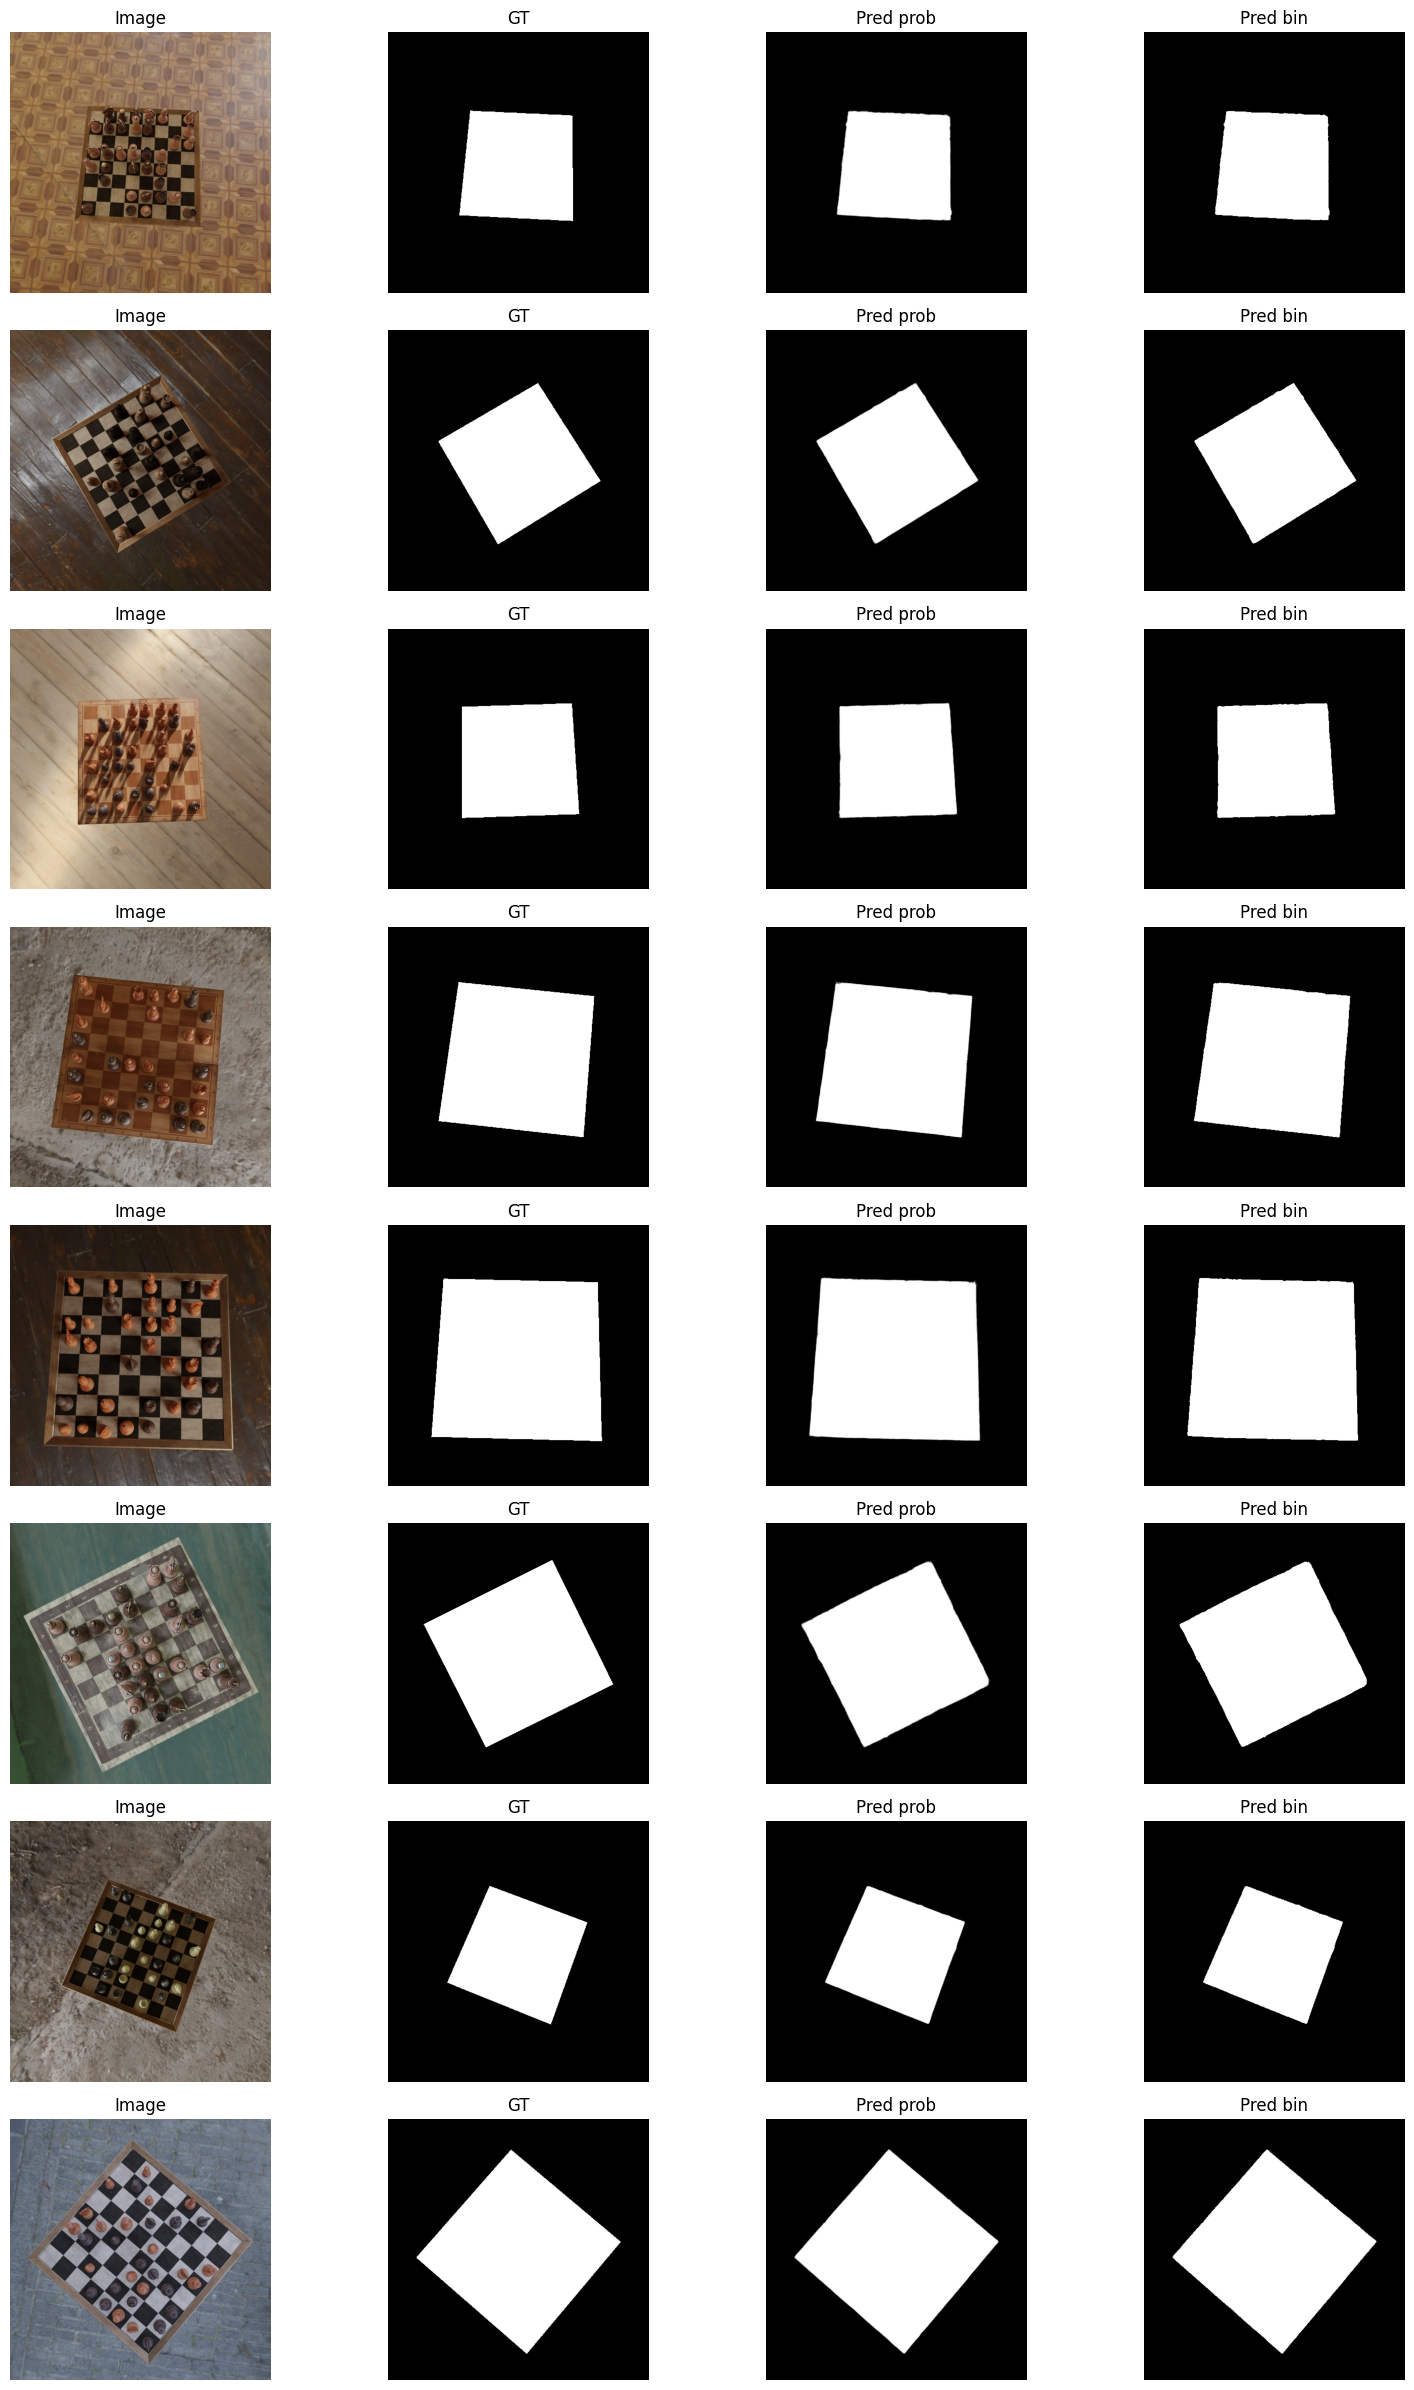

Best model path: checkpoints/unet_best.pt
Split dataset path: /content/dataset_final
Sample masks saved under: /content/dataset_final /{train,val,test}/masks


In [ ]:
def visualize_and_save(model, loader, out_dir=None, n=8, threshold=0.5):
    model.eval()
    saved = 0
    fig_items = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(DEVICE); masks = masks.to(DEVICE)
            preds = model(imgs)
            imgs_np = imgs.cpu().numpy(); masks_np = masks.cpu().numpy(); preds_np = preds.cpu().numpy()
            for i in range(imgs_np.shape[0]):
                im = np.transpose(imgs_np[i], (1,2,0))
                im = im * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
                im = np.clip(im, 0, 1)
                gt = masks_np[i][0]
                pr = preds_np[i][0]
                pr_bin = (pr > threshold).astype(np.uint8)
                fig_items.append((im, gt, pr, pr_bin))
                if out_dir is not None:
                    save_mask_path = Path(out_dir) / f"pred_{saved:04d}.png"
                    cv2.imwrite(str(save_mask_path), (pr_bin*255).astype(np.uint8))
                saved += 1
                if saved >= n:
                    break
            if saved >= n:
                break

    if len(fig_items) == 0:
        print("No items to visualize")
        return

    rows = len(fig_items)
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    # ensure axes is 2D
    if rows == 1:
        axes = axes[np.newaxis, :]

    for r, (im, gt, pr, pr_bin) in enumerate(fig_items):
        axes[r, 0].imshow(im);   axes[r, 0].set_title("Image");     axes[r, 0].axis("off")
        axes[r, 1].imshow(gt, cmap="gray"); axes[r, 1].set_title("GT");       axes[r, 1].axis("off")
        axes[r, 2].imshow(pr, cmap="gray"); axes[r, 2].set_title("Pred prob"); axes[r, 2].axis("off")
        axes[r, 3].imshow(pr_bin, cmap="gray"); axes[r, 3].set_title("Pred bin"); axes[r, 3].axis("off")

    plt.tight_layout()
    plt.show()


visualize_and_save(model, val_loader, out_dir=None, n=8, threshold=0.5)

print("Best model path: checkpoints/unet_best.pt")
print("Split dataset path:", OUT_DIR)
if SAVE_MASKS:
    print("Sample masks saved under:", OUT_DIR, "/{train,val,test}/masks")

In [ ]:
import torch
from pathlib import Path
import numpy as np
import cv2

# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) instantiate model architecture (must match the saved model)
# from your_model_file import UNet
model = UNet(in_ch=3, out_ch=1)   # adjust signature to your implementation
model = model.to(DEVICE)

# 2) load checkpoint (state_dict)
ckpt_path = "/content/checkpoints/unet_best.pt"

def load_state_dict_flexible(model, ckpt_path, device=DEVICE):
    sd = torch.load(ckpt_path, map_location=device)
    # sometimes people save a dict with keys like {"model": state_dict, "epoch":..., ...}
    if isinstance(sd, dict) and "state_dict" in sd:
        sd = sd["state_dict"]
    # if someone saved the whole model: torch.save(model)
    if not isinstance(sd, dict):
        # sd is a model object -> try loading its state_dict
        try:
            sd = sd.state_dict()
        except Exception:
            raise RuntimeError("Checkpoint format not recognized.")
    # strip "module." prefix if present (DataParallel / DistributedDataParallel)
    new_sd = {}
    for k, v in sd.items():
        new_k = k
        if k.startswith("module."):
            new_k = k[len("module."):]
        new_sd[new_k] = v
    model.load_state_dict(new_sd)
    return model

model = load_state_dict_flexible(model, ckpt_path, device=DEVICE)
model.eval()
print("Loaded weights from:", ckpt_path)

Loaded weights from: /content/checkpoints/unet_best.pt


In [ ]:
# robust_quad_refine_fixed.py
import cv2
import numpy as np
from pathlib import Path
import math

IMG_PATH = Path("/content/frame_000000.png")
OUT_DIR  = Path("/content/unet_infer_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def crop_black_bars(img, bright_thresh=10):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > bright_thresh
    coords = np.argwhere(mask)
    if coords.size == 0:
        return img, (0,0,img.shape[1], img.shape[0])
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1
    return img[y0:y1, x0:x1], (x0, y0, x1, y1)

def order_corners_clockwise(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = pts[:,0] - pts[:,1]
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

def approx_quad_from_contour(cnt):
    peri = cv2.arcLength(cnt, True)
    for eps_ratio in [0.005, 0.01, 0.02, 0.04, 0.08]:
        eps = max(1.0, eps_ratio * peri)
        approx = cv2.approxPolyDP(cnt, eps, True)
        if len(approx) == 4:
            return approx.reshape(4,2)
    return None

def try_white_frame_mask(img):
    H, W = img.shape[:2]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    v = hsv[:,:,2].astype(np.uint8)
    s = hsv[:,:,1].astype(np.uint8)
    L = lab[:,:,0].astype(np.uint8)
    white_mask = (v > np.percentile(v, 60)) & (s < np.percentile(s, 60))
    white_mask = white_mask & (L > np.percentile(L, 50))
    m = (white_mask.astype(np.uint8) * 255)
    k = max(5, int(min(H,W) * 0.01))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel, iterations=2)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=1)
    return m

def find_quad_from_mask(mask):
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None, mask
    cnt = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    if area < 1000:
        return None, mask
    quad = approx_quad_from_contour(cnt)
    if quad is not None:
        return quad, mask
    hull = cv2.convexHull(cnt)
    quad = approx_quad_from_contour(hull)
    if quad is not None:
        return quad, mask
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    return box, mask

def hough_line_quad(img_gray):
    g = cv2.GaussianBlur(img_gray, (5,5), 0)
    edges = cv2.Canny(g, 40, 120)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80,
                            minLineLength=max(20, min(img_gray.shape)//6), maxLineGap=30)
    if lines is None:
        return None, edges
    lines = [l[0] for l in lines]
    angles = np.array([math.atan2(y2-y1, x2-x1) for (x1,y1,x2,y2) in lines])
    angles = (angles + np.pi/2) % np.pi - np.pi/2
    idxs = np.argsort(angles)
    half = len(angles)//2
    c1 = [lines[i] for i in idxs[:half]] if half>0 else lines
    c2 = [lines[i] for i in idxs[half:]] if half>0 else lines
    def extremes(cluster):
        if not cluster:
            return []
        vx = np.mean([x2-x1 for (x1,y1,x2,y2) in cluster])
        vy = np.mean([y2-y1 for (x1,y1,x2,y2) in cluster])
        nx, ny = -vy, vx
        nlen = math.hypot(nx, ny) + 1e-9
        nx /= nlen; ny /= nlen
        mids = []
        for (x1,y1,x2,y2) in cluster:
            mx = (x1+x2)/2; my = (y1+y2)/2
            proj = mx*nx + my*ny
            mids.append((proj, (x1,y1,x2,y2)))
        mids_sorted = sorted(mids, key=lambda x: x[0])
        if len(mids_sorted) >= 2:
            return [mids_sorted[0][1], mids_sorted[-1][1]]
        else:
            return [cluster[0], cluster[0]]
    fam1 = extremes(c1)
    fam2 = extremes(c2)
    pts = []
    def line_to_abcd(l):
        x1,y1,x2,y2 = l
        a = y2 - y1; b = x1 - x2; c = a*x1 + b*y1
        return a,b,c
    for l1 in fam1:
        for l2 in fam2:
            a1,b1,c1 = line_to_abcd(l1)
            a2,b2,c2 = line_to_abcd(l2)
            det = a1*b2 - a2*b1
            if abs(det) < 1e-6:
                continue
            ix = (c1*b2 - c2*b1) / det
            iy = (a1*c2 - a2*c1) / det
            pts.append([ix, iy])
    if len(pts) == 4:
        return np.array(pts, dtype=np.float32), edges
    return None, edges

def refine_corners_subpix(gray, corners, win=10):
    if corners is None:
        return None
    pts = np.array(corners, dtype=np.float32).reshape(-1,2)
    H,W = gray.shape[:2]
    for (x,y) in pts:
        if not (0 <= x < W and 0 <= y < H):
            return pts  # out-of-bounds: skip refine
    pts_for = pts.reshape(-1,1,2).astype(np.float32)
    gray_u8 = gray if gray.dtype==np.uint8 else (np.clip(gray,0,1)*255).astype(np.uint8)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
    try:
        cv2.cornerSubPix(gray_u8, pts_for, (win,win), (-1,-1), criteria)
        return pts_for.reshape(-1,2)
    except Exception:
        return pts

def validate_quad(quad, img_shape):
    # robust validation: ensure quad exists, shape Nx2, cast to int32 for contourArea
    if quad is None:
        return False
    arr = np.asarray(quad)
    if arr.size == 0:
        return False
    if arr.ndim != 2 or arr.shape[1] < 2:
        return False
    if arr.shape[0] < 3:
        return False
    # convert to int32 for contour operations
    try:
        contour = arr.reshape(-1,1,2).astype(np.int32)
    except Exception:
        return False
    H,W = img_shape[:2]
    xs = contour[:,:,0].reshape(-1)
    ys = contour[:,:,1].reshape(-1)
    if np.any(xs < -100) or np.any(xs > W+100) or np.any(ys < -100) or np.any(ys > H+100):
        return False
    area = cv2.contourArea(contour)
    if area <= 0:
        return False
    if area < 0.01 * W * H:  # require at least 1% of image area (tunable)
        return False
    # squareness
    pts = arr.reshape(-1,2).astype(np.float32)
    d = [np.linalg.norm(pts[(i+1)%pts.shape[0]] - pts[i]) for i in range(pts.shape[0])]
    mean = np.mean(d); std = np.std(d)
    if mean <= 0:
        return False
    if (std / (mean + 1e-9)) > 1.0:  # allow more variance but reject extremely irregular
        return False
    return True

# main strategy runner (same as before, but using fixed validate_quad)
def run_all_strategies(img_bgr):
    cropped, (x0,y0,x1,y1) = crop_black_bars(img_bgr)
    Hc,Wc = cropped.shape[:2]
    debug_imgs = {}
    white_mask = try_white_frame_mask(cropped)
    debug_imgs['white_mask'] = white_mask.copy()
    quad, mask = find_quad_from_mask(white_mask)
    if quad is not None:
        quad_ord = order_corners_clockwise(quad)
        gray_c = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        refined = refine_corners_subpix(gray_c, quad_ord, win=10)
        if refined is not None:
            quad_ord = refined
        quad_full = quad_ord + np.array([x0, y0])
        if validate_quad(quad_full, img_bgr.shape):
            return quad_full, {'method':'white_mask', 'debug':debug_imgs}
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 7)
    thr = cv2.bitwise_not(thr)
    k = max(5, int(min(Hc,Wc)*0.01))
    thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k,k)), iterations=2)
    quad2, mask2 = find_quad_from_mask(thr)
    debug_imgs['adaptive_mask'] = thr.copy()
    if quad2 is not None:
        quad2_ord = order_corners_clockwise(quad2)
        refined = refine_corners_subpix(gray, quad2_ord, win=10)
        if refined is not None:
            quad2_ord = refined
        quad2_full = quad2_ord + np.array([x0,y0])
        if validate_quad(quad2_full, img_bgr.shape):
            return quad2_full, {'method':'adaptive', 'debug':debug_imgs}
    qh, edges = hough_line_quad(gray)
    debug_imgs['edges'] = edges
    if qh is not None:
        qh_ord = order_corners_clockwise(qh)
        refined = refine_corners_subpix(gray, qh_ord, win=10)
        if refined is not None:
            qh_ord = refined
        qh_full = qh_ord + np.array([x0,y0])
        if validate_quad(qh_full, img_bgr.shape):
            return qh_full, {'method':'hough', 'debug':debug_imgs}
    pts = cv2.goodFeaturesToTrack(gray, maxCorners=500, qualityLevel=0.01, minDistance=10)
    debug_imgs['goodcorners'] = np.zeros_like(gray)
    if pts is not None:
        pts2 = pts.reshape(-1,2)
        for (xx,yy) in pts2.astype(int):
            cv2.circle(debug_imgs['goodcorners'], (xx,yy), 1, 255, -1)
        hull = cv2.convexHull(pts2.astype(np.float32))
        qhull = approx_quad_from_contour(hull)
        if qhull is not None:
            qhull_ord = order_corners_clockwise(qhull)
            refined = refine_corners_subpix(gray, qhull_ord, win=10)
            if refined is not None:
                qhull_ord = refined
            qhull_full = qhull_ord + np.array([x0,y0])
            if validate_quad(qhull_full, img_bgr.shape):
                return qhull_full, {'method':'corners_hull', 'debug':debug_imgs}
    combined = cv2.bitwise_or(white_mask, thr)
    cnts, _ = cv2.findContours(combined.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        c = max(cnts, key=cv2.contourArea)
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box_full = box + np.array([x0,y0])
        if validate_quad(box_full, img_bgr.shape):
            debug_imgs['fallback_minrect'] = combined
            return box_full.astype(int), {'method':'minrect_fallback', 'debug':debug_imgs}
    return None, {'method':'none', 'debug':debug_imgs}

# Run
img = cv2.imread(str(IMG_PATH))
if img is None:
    raise FileNotFoundError("Image not found: " + str(IMG_PATH))

quad, info = run_all_strategies(img)
print("Chosen method:", info['method'])
if quad is None:
    print("Failed to detect a valid quad. Saved debug images for inspection.")
    for k,v in info['debug'].items():
        if v is None: continue
        path = OUT_DIR / f"debug_{k}.png"
        out = v
        if out.dtype != np.uint8:
            out = (np.clip(out,0,1)*255).astype(np.uint8) if out.max()<=1.0 else out.astype(np.uint8)
        cv2.imwrite(str(path), out)
        print("Wrote", path)
else:
    quad_ord = order_corners_clockwise(np.array(quad))
    print("Detected corners (TL,TR,BR,BL):")
    for i,(x,y) in enumerate(quad_ord):
        print(f" {i}: ({int(round(x))}, {int(round(y))})")
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, [quad_ord.reshape(-1,1,2).astype(int)], 255)
    cv2.imwrite(str(OUT_DIR/"mask_best.png"), mask)
    vis = img.copy()
    cv2.polylines(vis, [quad_ord.reshape(-1,1,2).astype(int)], True, (0,255,0), 4)
    for i,(x,y) in enumerate(quad_ord):
        cv2.circle(vis, (int(round(x)), int(round(y))), 8, (0,255,0), -1)
        cv2.putText(vis, str(i+1), (int(round(x))+6, int(round(y))-6), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 3)
    cv2.imwrite(str(OUT_DIR/"overlay_best.png"), vis)
    print("Saved mask_best.png and overlay_best.png to", OUT_DIR)


Chosen method: white_mask
Detected corners (TL,TR,BR,BL):
 0: (105, 500)
 1: (222, 1446)
 2: (1008, 1494)
 3: (1023, 442)
Saved mask_best.png and overlay_best.png to /content/unet_infer_out


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, features=[64,128,256,512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        prev = in_ch
        for f in features:
            self.downs.append(DoubleConv(prev, f))
            prev = f
        self.pool = nn.MaxPool2d(2,2)
        self.bottleneck = DoubleConv(prev, prev*2)
        prev = prev*2
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(prev, f, 2, 2))
            self.ups.append(DoubleConv(prev, f))
            prev = f
        self.final_conv = nn.Conv2d(prev, out_ch, 1)

    def forward(self, x):
        skips = []
        out = x
        for d in self.downs:
            out = d(out)
            skips.append(out)
            out = self.pool(out)
        out = self.bottleneck(out)
        for i in range(0, len(self.ups), 2):
            out = self.ups[i](out)
            skip = skips[-1 - (i//2)]
            if out.size()[2:] != skip.size()[2:]:
                out = nn.functional.interpolate(out, size=skip.shape[2:])
            out = torch.cat((skip, out), dim=1)
            out = self.ups[i+1](out)
        return torch.sigmoid(self.final_conv(out))


In [ ]:
model = UNet().to(DEVICE)
ckpt = torch.load("/content/checkpoints/unet_best.pt", map_location=DEVICE)
model.load_state_dict(ckpt)
model.eval()
print("U-Net loaded.")


U-Net loaded.


In [ ]:
def infer_mask(img_path):
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    im = cv2.resize(rgb, (512,512))
    im_t = torch.tensor(im/255.0).float().permute(2,0,1).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(im_t)[0,0].cpu().numpy()

    mask512 = (pred > 0.5).astype(np.uint8)

    mask = cv2.resize(mask512, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    cv2.imwrite("/content/unet_infer_out/pred_mask.png", mask*255)
    return img, mask


In [ ]:
def extract_corners(mask):
    mask_u8 = mask.astype(np.uint8)*255

    cnts,_ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        print("No contour found")
        return None

    cnt = max(cnts, key=cv2.contourArea)
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02*peri, True)

    if len(approx) != 4:
        print("Polygon ≠ 4 sides → forcing minAreaRect")
        rect = cv2.minAreaRect(cnt)
        approx = cv2.boxPoints(rect)

    pts = approx.reshape(-1, 2)
    return order_corners(pts)


In [ ]:
def order_corners(pts):
    pts = np.array(pts)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    TL = pts[np.argmin(s)]
    BR = pts[np.argmax(s)]
    TR = pts[np.argmin(diff)]
    BL = pts[np.argmax(diff)]

    return np.array([TL, TR, BR, BL], dtype=float)


In [ ]:
def save_overlay(img, corners):
    vis = img.copy()
    pts = corners.astype(int)

    cv2.polylines(vis, [pts], True, (0,255,0), 4)

    for i,(x,y) in enumerate(pts):
        cv2.circle(vis, (x,y), 8, (0,255,0), -1)
        cv2.putText(vis, str(i+1), (x+10,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    cv2.imwrite("/content/unet_infer_out/overlay.png", vis)
    print("Saved overlay:", "/content/unet_infer_out/overlay.png")


In [ ]:
img, mask = infer_mask("/content/sharp_sobel.png")
corners = extract_corners(mask)

print("Corners:", corners)
save_overlay(img, corners)


Corners: [[ 169.  570.]
 [ 963.  510.]
 [ 966. 1421.]
 [ 138. 1379.]]
Saved overlay: /content/unet_infer_out/overlay.png


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# U-NET ARCHITECTURE USED FOR TRAINING
# -------------------------------

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, features=[64,128,256,512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        prev = in_ch

        for f in features:
            self.downs.append(DoubleConv(prev, f))
            prev = f

        self.pool = nn.MaxPool2d(2,2)
        self.bottleneck = DoubleConv(prev, prev*2)
        prev = prev*2

        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(prev, f, 2, 2))
            self.ups.append(DoubleConv(prev, f))
            prev = f

        self.final_conv = nn.Conv2d(prev, out_ch, 1)

    def forward(self, x):
        skips = []
        out = x

        for d in self.downs:
            out = d(out)
            skips.append(out)
            out = self.pool(out)

        out = self.bottleneck(out)

        for i in range(0, len(self.ups), 2):
            out = self.ups[i](out)
            skip = skips[-1 - (i//2)]

            if out.size()[2:] != skip.size()[2:]:
                out = nn.functional.interpolate(out, size=skip.shape[2:])

            out = torch.cat((skip, out), dim=1)
            out = self.ups[i+1](out)

        return torch.sigmoid(self.final_conv(out))


# -------------------------------
# LOAD MODEL
# -------------------------------

def load_unet(path):
    model = UNet().to(DEVICE)
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt)
    model.eval()
    print("U-Net Loaded.")
    return model


# -------------------------------
# IMAGE ENHANCEMENT METHODS
# -------------------------------

def apply_sobel(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sx = cv2.Sobel(gray, cv2.CV_16S, 1, 0, ksize=3)
    sy = cv2.Sobel(gray, cv2.CV_16S, 0, 1, ksize=3)
    sob = cv2.convertScaleAbs(0.5*sx + 0.5*sy)
    sharp = cv2.addWeighted(gray, 1.0, sob, 0.7, 0)
    return cv2.cvtColor(sharp, cv2.COLOR_GRAY2BGR)


def apply_log(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    lap = cv2.Laplacian(blur, cv2.CV_64F, ksize=3)
    lap = cv2.convertScaleAbs(lap)
    sharp = cv2.addWeighted(gray, 1.2, lap, -0.5, 0)
    return cv2.cvtColor(sharp, cv2.COLOR_GRAY2BGR)


# -------------------------------
# U-NET INFERENCE
# -------------------------------

def unet_predict(model, img):
    h, w = img.shape[:2]
    resized = cv2.resize(img, (512,512))
    t = torch.tensor(resized/255.0).float().permute(2,0,1).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(t)[0,0].cpu().numpy()

    mask512 = (pred > 0.5).astype(np.uint8)
    mask = cv2.resize(mask512, (w,h), interpolation=cv2.INTER_NEAREST)
    return mask


# -------------------------------
# CORNER EXTRACTION
# -------------------------------

def order_corners(pts):
    pts = np.array(pts)
    s  = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    TL = pts[np.argmin(s)]
    BR = pts[np.argmax(s)]
    TR = pts[np.argmin(diff)]
    BL = pts[np.argmax(diff)]

    return np.array([TL, TR, BR, BL], float)

def extract_corners(mask):
    cnts,_ = cv2.findContours(mask.astype(np.uint8)*255,
                              cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not cnts:
        return None

    cnt = max(cnts, key=cv2.contourArea)
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02*peri, True)

    if len(approx) != 4:
        rect = cv2.minAreaRect(cnt)
        approx = cv2.boxPoints(rect)

    return order_corners(approx.reshape(-1,2))


# -------------------------------
# MAIN: COMBINE SOBEL + LOG
# -------------------------------

IMG_PATH = "/content/frame_000000.png"
MODEL_PATH = "/content/drive/MyDrive/U-Net/unet_best.pt"

model = load_unet(MODEL_PATH)
img = cv2.imread(IMG_PATH)

# 1. Apply Sobel & LoG
sobel_img = apply_sobel(img)
log_img   = apply_log(img)

# 2. Predict masks
mask_sobel = unet_predict(model, sobel_img)
mask_log   = unet_predict(model, log_img)

# 3. Extract corners
corners_sobel = extract_corners(mask_sobel)
corners_log   = extract_corners(mask_log)

print("Corners Sobel:", corners_sobel)
print("Corners LoG:", corners_log)

if corners_sobel is None or corners_log is None:
    raise RuntimeError("One method failed to detect corners!")

# 4. Average both results
corners_avg = (corners_sobel + corners_log) / 2.0
print("Averaged Corners:", corners_avg)


# -------------------------------
# DRAW RESULT
# -------------------------------

vis = img.copy()
pts = corners_avg.astype(int)

cv2.polylines(vis, [pts], True, (0,255,0), 4)

for i,(x,y) in enumerate(pts):
    cv2.circle(vis, (x,y), 8, (0,255,0), -1)
    cv2.putText(vis, str(i+1), (x+10,y-10)
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

cv2.imwrite("/content/fused_corners.png", vis)
print("Saved → /content/fused_corners.png")


U-Net Loaded.
Corners Sobel: [[ 169.  570.]
 [ 963.  510.]
 [ 966. 1421.]
 [ 138. 1379.]]
Corners LoG: [[ 151.66113281  480.89422607]
 [ 982.58129883  501.16052246]
 [ 960.15319824 1420.7109375 ]
 [ 129.23303223 1400.44470215]]
Averaged Corners: [[ 160.33056641  525.44711304]
 [ 972.79064941  505.58026123]
 [ 963.07659912 1420.85546875]
 [ 133.61651611 1389.72235107]]
Saved → /content/fused_corners.png
